In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
  
# append the path of the parent directory
sys.path.append("..")

import time
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from models import UNet
import utils

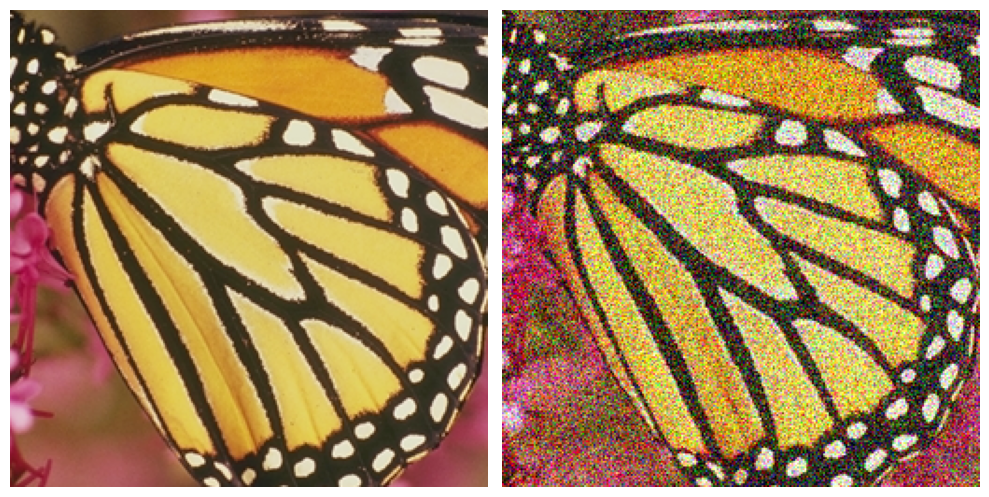

In [15]:
x = utils.load_image('../data/set5/butterfly.png')
# x = utils.load_celeba(1)
x_hat = torch.stack([utils.get_noisy_image(img, 0.2) for img in x])
utils.plot_row([x, x_hat])

In [16]:
input_channels = 3
deep_channels = [8, 16, 32, 64, 128]
skip_channels = [0, 0, 0, 4, 4]

lr = 0.01

In [17]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net1 = UNet(input_channels, deep_channels, skip_channels)
net1.to(device)

net2 = UNet(input_channels, deep_channels, skip_channels)
net2.to(device)
net2.load_state_dict(net1.state_dict())

optimizer1 = optim.Adam(net1.parameters(), lr)
optimizer2 = optim.Adam(net2.parameters(), lr)

mse = nn.MSELoss()
psnr = PeakSignalNoiseRatio().to(device)

x = x.to(device)
x_hat = x_hat.to(device)

input_shape = [input_channels if i == 1 else s for i, s in enumerate(x_hat.size())]
z1 = torch.rand(input_shape, device=device) * 0.1
z2 = torch.rand(input_shape, device=device) * 0.1

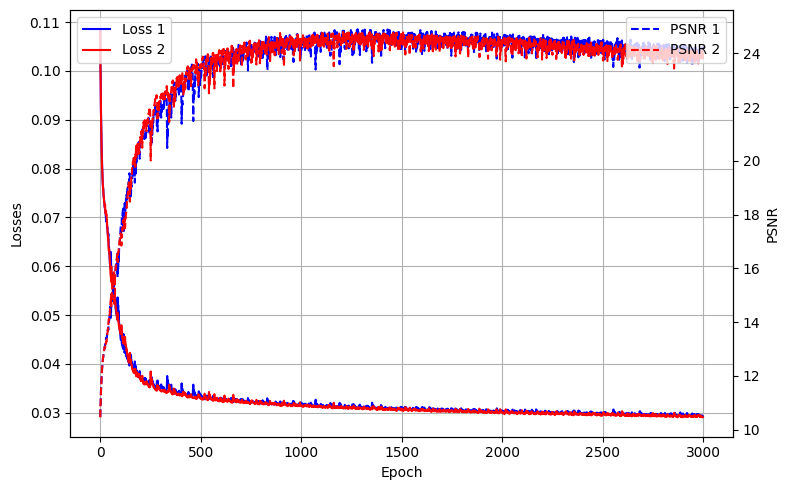

----------
Finished training in 00:03:09



In [18]:
print(f'Training on {device}')
start = time.time()

losses1 = []
psnrs1 = []
losses2 = []
psnrs2 = []
diffs = []

for t in range(3000):
  net1.train()
  net2.train()
  optimizer1.zero_grad()
  optimizer2.zero_grad()

  out1 = net1(z1)
  out2 = net2(z2)
  loss1 = mse(out1, x_hat)
  loss2 = mse(out2, x_hat)
  loss1.backward()
  loss2.backward()
  optimizer1.step()
  optimizer2.step()

  net1.eval()
  net2.eval()

  losses1.append(loss1.item())
  losses2.append(loss2.item())
  psnrs1.append(psnr(out1, x).item())
  psnrs2.append(psnr(out2, x).item())

  if t % 100 == 99:
    clear_output(wait=True)
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.grid()

    ax1.plot(losses1, 'b-', label='Loss 1')
    ax1.plot(losses2, 'r-', label='Loss 2')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Losses')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(psnrs1, 'b--', label='PSNR 1')
    ax2.plot(psnrs2, 'r--', label='PSNR 2')
    ax2.set_ylabel('PSNR')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.show()

  t += 1

duration = time.time() - start
print('----------')
print(f'Finished training in {time.strftime('%H:%M:%S', time.gmtime(duration))}\n')